# Cuantización de Color

La cuantización de color es un proceso utilizado para reducir el número de colores en una imagen, manteniendo al mismo tiempo una apariencia visual similar a la original. Dado que las imágenes digitales pueden contener millones de colores, la cuantización es especialmente útil para disminuir la complejidad de la imagen, lo que reduce el tamaño de almacenamiento o facilita el procesamiento en aplicaciones específicas.

El objetivo es seleccionar una paleta limitada de colores que represente bien los tonos de la imagen original. Luego, cada píxel se asigna al color más cercano dentro de esa paleta. Este proceso se puede realizar usando técnicas de clustering, como k-means, k-medoids, y clustering jerárquico, que agrupan los colores similares y escogen representaciones de cada grupo.

Usos de la cuantización de color:

* **Compresión de imágenes**: Se utiliza para reducir el tamaño de archivos de imágenes sin una gran pérdida perceptible de calidad, como en la creación de imágenes en formatos con paletas de colores limitadas, como GIF o PNG.
* **Procesamiento y análisis de imágenes:** Simplificar la gama de colores ayuda a mejorar la eficiencia en tareas como la segmentación de imágenes, la detección de bordes y el reconocimiento de patrones.
* **Visualización y gráficos computacionales**: En dispositivos con capacidades limitadas de color, como algunos monitores o impresoras, la cuantización permite adaptar las imágenes a estas restricciones de hardware.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [2]:
# Preprocessing and Utilities
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle

In [3]:
# Clustering algorithms
from sklearn.cluster import KMeans, AffinityPropagation, AgglomerativeClustering
from sklearn_extra.cluster import KMedoids

In [4]:
# Metrics for evaluation
from sklearn.metrics import mean_squared_error
from skimage import color, img_as_float
from skimage.metrics import structural_similarity as ssim

## Carga de Datos

In [5]:
# Carga de imagenes
img_names = ['Bosch','Boticelli','Dali','Monet','Picaso','VanGogh','Velazquez','Vermeer']
path = './Paintings/'

imgs = {}
for i in range(len(img_names)):
    temp = cv2.imread(path+img_names[i]+'.jpg')
    imgs[img_names[i]] = temp

# Función para mostrar imagenes
def show(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

### Definición de cantidad de colores y muestras

In [9]:
# definimos la paleta de colores máxima para la cuantización de colores
n_colors = 15
data = {}
n_samples = 1000

##  Preprocesamiento de Datos

Para poder llevar a cabo la cuantización de colores, se llevará a cabo el siguiente preprocesamiento de los datos: 

**Reducción de Resolución**: Las imagenes, dependiendo de su resolución, pueden estar constituidas por una gran cantidad de píxeles para poder obtener una representación lo más suave, entiendase la dificultad para distinguir los píxeles entre sí, y de mayor calidad posible, lo que en materia de representación resulta muy útil, pero que para el ejercicio presente desarrolla un nuevo reto por el hecho de que una mayor cantidad de pixeles representa una mayor cantidad de valores similares a procesar. Esto, para aquellos algoritmos cuya complejidad espacial se acerque o supere $O(n^2)$, representa un desaf[io debido al alto consumo de memoria en el que se incurre. 

Para poder evitar esta situación, se llevará acabo el proceso de disminución de densidad de las imagenes, para aligerar el costo de procesamiento de los algoritmos y poder evitar o disminuir el consumo de recursos. 

**Flattening o Aplanamiento de la imagen**: Las imagenes son matrices multidimensionales de pixeles pertenecientes a un espacio de color, como puede ser RGB, normalmente en 3D para poder representar cada unode los diferentes colores. Sin embargo, algunos de los algoritmos empleados para cuantizar, como Kmeans o Kmedoids, esperan que se use como datos de entradas características representadas a través de arreglos en 2D, por lo que es necesario que se de un proceso de "aplanmiento" o cambio de forma en el arreglo de pixeles para que puedan emplearse, 


In [6]:
def reduce_res(image,h,w,p=0.8):
    # p es un valor entre 0 y 1, que determina la nueva dimension de la img
    nw = w*p

    nh = h*p
    reduced =  cv2.resize(image, (int(nw), int(nh)), interpolation=cv2.INTER_AREA)
    return (reduced,int(nh),int(nw))

In [7]:
# Function to flatten the image
def flatten_img(img,h,w):
    res =  np.reshape(img, ( (h*w),3 ))
    return res

# Function to return the image to its original form
def unflatten_img(img,h,w):
    res = img.reshape((h,w,3))
    return res

In [21]:
def pre_process(img,p=0.8):
    data ={}
    reduced = reduce_res(img,img.shape[0],img.shape[1],p)
    
    data['img'] = reduced[0]
    data['h'] = reduced[1]
    data['w'] = reduced[2]

    data['flat'] = flatten_img(data['img'],data['h'],data['w'])
    return data

def postprocess(clusters,data):
    temp = np.reshape(clusters.astype("uint8")[data['labels']],(data['h'],data['w'], 3))
    return temp

## Cuantización: KMeans

La reducción de cuantización de color usando **K-means** se basa en la idea de agrupar colores similares en la imagen en un número determinado de clusters, y luego reemplazar todos los colores dentro de cada cluster por un único color representativo. Este proceso consta de los siguientes pasos:
   - Cada píxel de la imagen puede ser considerado un vector en un espacio tridimensional (RGB), donde cada componente (R, G, B) es una dimensión. 
   - Se seleccionan aleatoriamente **k** centroides en el espacio de color. En nuestro caso como se trabaja con una paleta de 15 colores, se tendrán 15 centroides.  Estos centroides representan inicialmente los colores a los que se agruparán los demás píxeles.
   - En cada iteración, K-means asigna cada píxel al cluster cuyo centroide esté más cerca, basándose en la distancia euclidiana en el espacio de color RGB.
   - La fórmula para la distancia euclidiana entre un píxel \(x_i\) y un centroide \(c_j\) es:

   \[
   d(x_i, c_j) = \sqrt{(R_i - R_j)^2 + (G_i - G_j)^2 + (B_i - B_j)^2}
   \]

   - Después de que todos los píxeles hayan sido asignados a un cluster, el algoritmo recalcula el centroide de cada cluster.El cual será es el promedio de todos los píxeles asignados a ese cluster.
   - Esto se repitirá hasta que no se den cambios significativos o se llegue al máximo de iteraciones, el cual es 300 por defecto

   - Una vez que el algoritmo ha convergido, se reemplazan los colores originales de los píxeles por el color de su cluster correspondiente, es decir, el color del centroide de su cluster.

El resultado es una imagen en la que los colores originales han sido reemplazados por una paleta de **k** colores representativos. Estos colores corresponden a los centroides finales de los clusters formados por K-means.

Debido a la posible alta cantidad de pixeles que podrían existir aún después de la reducción y dada la naturaleza sensible de K Means a su inicialización, el modelo primero se entrenará primero con un subset de pixeles representativos para poder reducir la carga computacional aún más y facilitar luego el proceso de cuantización completo. 

In [10]:
def sampling(img,n_samples):
    return shuffle(img, random_state=0, n_samples=n_samples)

In [12]:
def kmeans_cuantization(imgs,n_colors,p,n_samples):
    data = {}
    res = {}
    for key,value in imgs.items():
        kmeans = KMeans(n_clusters=n_colors)
        data = pre_process(value,p)
        
        sample = sampling(data['flat'],n_samples)
        kmeans.fit(sample)
        data['labels'] = kmeans.predict(data['flat'])
        
        data['result'] = postprocess(kmeans.cluster_centers_,data)
        
        res[key] = {
            'org':data['img'],
            'red':data['result']
        }
        data = {}

    
    return ('kmeans',res)

### Cuantización: KMedoids

La cuantización de color usando **K-medoids** es similar a K-means, pero con una diferencia clave en la selección de los centroides. En lugar de usar el promedio de los puntos (colores) en cada cluster, K-medoids selecciona un color real de los datos como centroide, lo que hace que sea más robusto ante outliers o colores atípicos. Los pasos a seguir son los siguientes:

   - Cada píxel de la imagen es tratado como un punto en el espacio tridimensional de color **RGB**.

   - En lugar de seleccionar aleatoriamente puntos del espacio de color, se seleccionan 15 colores reales de la imagen como los primeros "medoids" (similares a los centroides de K-means).

   - Cada píxel se asigna al medoid más cercano en términos de la **distancia euclidiana** en el espacio de color RGB 

   - A diferencia de K-means, donde se recalcula el centroide como el promedio de los colores en un cluster, en K-medoids, el nuevo medoid es el píxel (o color) que minimiza la distancia total a todos los demás puntos (colores) dentro del cluster. Esto garantiza que el medoid siempre sea un color real presente en la imagen, en lugar de un valor promedio que podría no ser parte de la imagen original.
   - Para recalcular, el algoritmo evalúa varios píxeles dentro del cluster y elige el que minimice la suma de distancias a los demás píxeles del grupo.
   - El proceso de reasignación de píxeles a medoids y el recalculo de los medoids continúa iterativamente hasta que los medoids ya no cambian, o hasta alcanzar un número máximo de iteraciones.
   - Al finalizar, cada píxel de la imagen es reemplazado por el medoid del cluster al que pertenece. 


El resultado es una imagen que ha sido cuantizada a 15 colores, con cada píxel asignado al color (medoid) más cercano. A diferencia de K-means, los colores seleccionados como representantes de los clusters son colores existentes en la imagen original.


La implementación de scikit de Kmedoids sufre de que su peor caso en materia de espacio computacional es $O(n^2)$, lo que lo vuelve extremadamente costo de correr directamente con la imagen completa. 
Por esto, se usará una reducción del 50% (0.5 en función) o similar para las imagenes y es el principal motivo que Kmeans ocupe dicho valor, para poder realizar una comparación en igualda de condiciones. 

Así mismo, se aplicará la técnica de entrenamiento por muestreo previo a alimentarle la imagen completa. 

In [13]:
def kmedoids_cuantization(imgs,n_colors,p,n_samples):
    data = {}
    res = {}
    for key,value in imgs.items():
        kmedoids = KMedoids(n_clusters=n_colors,method='pam')
        data = pre_process(value,p)
        
        sample = sampling(data['flat'],n_samples)
        kmedoids.fit(sample)
        data['labels'] = kmedoids.predict(data['flat'])
        
        data['result']= postprocess(kmedoids.cluster_centers_,data)
        
        res[key] = {
            'org':data['img'],
            'red':data['result']
        }
        data = {}

    
    return ('kmedoids',res)

### Cuantización: Hierarchical Clustering


La cuantización de color usando **Clustering Jerárquico**funciona mediante la agrupación iterativa de colores similares de la imagen, formando una estructura jerárquica de clusters. El objetivo es reducir el número de colores en la imagen, agrupando píxeles en un número limitado de clusters, cada uno representando un color en la paleta final. Sus pasos son los siguientes:

   - Cada píxel de la imagen se trata como un punto en el espacio tridimensional **RGB**.

   - **Agglomerative Clustering** es un método jerárquico de tipo "bottom-up", lo que significa que comienza tratando cada píxel como un cluster independiente. Luego, de manera iterativa, fusiona los clusters más similares hasta que se alcanza el número de clusters deseado (en este caso, un máximo de 15).

3. **Criterio de fusión**:
   - En cada iteración, los dos clusters más cercanos en términos de la distancia promedio en este caso, calculada mediante la distancia euclideana.

   - El proceso continúa fusionando clusters hasta que solo queden **15 clusters**, como es tu límite especificado. Estos 15 clusters representarán la paleta de colores final.

   - Una vez que se han formado los 15 clusters, cada píxel de la imagen original se asigna al cluster más cercano, basado en la similitud de color.

   - Cada píxel de la imagen es reemplazado por el color representativo del cluster al que pertenece. Este color puede ser calculado como el promedio de todos los colores dentro del cluster o uno de los colores reales que compone el cluster.

### Desventajas:
- **Costo computacional**: Clustering Jerárquico de scikit learn, tiene un costo computacional mayor en comparación con K-means o K-medoids, ya que requiere calcular todas las distancias entre pares de clusters en cada paso, lo que puede ser más lento para imágenes grandes.
- **No tan eficiente para imágenes grandes**: En imágenes con muchos colores o resoluciones altas, el método puede volverse prohibitivo en términos de tiempo y memoria.

_**Aclaración**_: El algoritmo de clustering Jerárquico implementado en scikit learn sufre del mismo que problema Kmedoids, su costo espacial de $O(n^2)$ lo vuelva una tarea extremadamente costosa en materia de memora. Sin embargo, la solución empleada con Kmedoids, de primero entrar con algunas muestras para poder reducir el costo de computación no es posible con esta implementación ya que no cuenta con un método predict separado para realizar primero el muestreo y luego la predicción, si no que únicamente posee el método fit_predict, el cual aunque se emplee fit() previamente, realizará desde 0 todo el procedimiento, incurriendo en el alto costo mencionado

Esto, llevo a que se tuviera que utilizar reducciones de resolución muy grandes a las imagenes, entiendase reducciones del 90% de la imagen, llevandolás a verse pixeleadas en muchos casos y no pudiendo usar los mismos valores que Kmeans y Kmedoids, por lo que la comparación directa no se tomará en cuenta al no haber igualda de condiciones, solamente se usará para mostrar su funcionamiento y una mayor diversidad de métodos. 

In [512]:
hierarchical = AgglomerativeClustering(n_clusters=n_colors)

In [14]:
def hierarchical_cuantization(imgs,n_colors,p,n_samples):
    data = {}
    res = {}
    for key,value in imgs.items():
        hierarchical = AgglomerativeClustering(n_clusters=n_colors)
        data = pre_process(value,p)
        data['labels'] =hierarchical.fit_predict(data['flat'])
        
        cluster_centers = np.array([data['flat'][data['labels'] == i].mean(axis=0) for i in range(n_colors)])
        data['result']= postprocess(cluster_centers,data)
        
        res[key] = {
            'org':data['img'],
            'red':data['result']
        }
        data = {}

    
    return ('hierarchical',res)

## Evaluación de Resultados

Para evaluar los resultados de los algoritmos usados para la cunatización, se usarán 3 medidas, dos cuantitivas (MSE, SSIM) y una cualitativa (Delta-E). A continuación se brinda una breve explicación de cada una de ellas y el porqué de su uso: 

* MSE: Medida cuantitativa, la cual devolverá el la diferencia del promedio cuadrada de los pixeles entre ambas imágenes, evaluando de esta forma la diferencia entre los valores de los pixeles de ambas imágenes. Al ser meramente cuantitativa y basandosé solamente en similitudes, sus resultados pueden indicar que imágenes que no son tan similares al ojo humano son más similares a un nivel mátematico.
  
* SSIM: Es una medida cuantitativa conceptual, la cual evalúa los cambios y diferencias en contraste, ilumniación e información estructural, para modelar la forma en que precibimos las imágenes y su calidad, para dar una medición más robusta que MSE.

  
* Delta-E: Es una medida más cualitativa que las anteriores, ya que mide la de percepción entre dos colores en un espacio uniforme de color. En este caso, se usará el espacio de color CIELAB, que se diseño para aproximarse a la forma de visión humana y fuciona de la siguiente manera: *L* representa el grado de brillo de una imagen. en un rango de 0 a 100; *a* es el eje rojo-verde, donde valores positivos indican un mayor tono rojizo y valores negativos uno verde; *b* un indice azul-amarillo, siendo valores positivos más cercanos al amarillo y negativos al azul.

  En su caso, sus valores van desde 0 a 100 de la siguiente manera:

      <= 1.0 - No es perceptible al ojo humano la diferencia

      1-2 La diferencia se nota al inspeccionarlo de forma minuciosa

      2-10 La diferencia es perceptible al mirarle

      11-49 Los colores son más similares que opustos

      50-99 Los colores son más opuestos que similares

      100 Los colores son completamente diferentes


  Fuente: http://zschuessler.github.io/DeltaE/learn/


In [130]:
def delta_e(original, reduced):
    # Convert images to LAB color space
    lab_original = color.rgb2lab(original)
    lab_reduced = color.rgb2lab(reduced)
    
    # Compute the Delta-E (color difference)
    delta_e = color.deltaE_cie76(lab_original, lab_reduced)
    return np.mean(delta_e)  # Average color difference


In [16]:
def metrics(original,reduced):
    res = {}
    f_org= img_as_float(original)
    f_res = img_as_float(reduced)
    res['MSE'] = mean_squared_error(original.flatten(), reduced.flatten())
    res['SSIM'] = ssim(f_org, f_res, full=True, multichannel=True,channel_axis=2,data_range=f_res.max()-f_res.min())[0]
    res['Delta-E'] = delta_e(original,reduced)
    return res
    

In [17]:
def calculate_metrics(results):
    for key,value in results.items():
        results[key]['metrics'] =  metrics(results[key]['org'],results[key]['red'])
    return 

In [18]:
def show_result(original,reduced,metrics):
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.imshow(cv2.cvtColor(reduced, cv2.COLOR_BGR2RGB))
    print(f" Resultado de MSE: {metrics['MSE']} \n Resultado de SSIM:{metrics['SSIM']} \n Resultado Delta-E: {metrics['Delta-E']}")

In [197]:
quantizations = {}

temp = kmeans_cuantization(imgs,n_colors,0.5,n_samples)
calculate_metrics(temp[1])
quantizations[temp[0]] = temp[1]


In [198]:
temp = kmedoids_cuantization(imgs,n_colors,0.5,n_samples)
calculate_metrics(temp[1])
quantizations[temp[0]] = temp[1]

In [191]:
temp = hierarchical_cuantization(imgs,n_colors,0.1,n_samples)
calculate_metrics(temp[1])
quantizations[temp[0]] = temp[1]

## Representación de Todas las imágenes

In [193]:
# Función que muestra todas las imagenes, si se le pasa el parámetro de extended como Ture, muestra los valores de los errores de los metodos. Sin embargo, no esta optimizado visualmente
def gallery(q,names,figsize,extended=False):
    methods = ['kmeans', 'kmedoids', 'hierarchical']
    titles = ['Original', 'KMeans', 'KMedoids', 'Hierarchical']
    rows = len(names)

    if extended:
        rows = 2*len(names)
    fig, axs = plt.subplots(nrows=rows, ncols=4, figsize=figsize)  # Adjusted figsize
    j = 0
    for i in names:
        axs[j,0].imshow(cv2.cvtColor(q[methods[0]][i]['org'], cv2.COLOR_BGR2RGB))
        axs[j,1].imshow(cv2.cvtColor(q[methods[0]][i]['red'], cv2.COLOR_BGR2RGB))
        axs[j,2].imshow(cv2.cvtColor(q[methods[1]][i]['red'], cv2.COLOR_BGR2RGB))
        axs[j,3].imshow(cv2.cvtColor(q[methods[2]][i]['red'], cv2.COLOR_BGR2RGB))
         # Add title for each method
        for t in range(4):
            axs[j,t].set_title(titles[t], fontsize=16)
            
        for ax in axs[j]:
            ax.axis('off')
            
        if extended:
            j += 1
            
            for k in range(3):
                mse = q[methods[k]][i]['metrics']['MSE']
                ss = q[methods[k]][i]['metrics']['SSIM']
                delta = q[methods[k]][i]['metrics']['Delta-E']

               
            
                # Add text below each image 
                axs[j,k+1].text(0.5, 0.01, f'MSE: {mse:.2f}\nSSIM: {ss:.2f}\nΔE: {delta:.2f}',
                               fontsize=12,ha="center")
                for ax in axs[j]:
                    ax.axis('off')
            
        
        j += 1
        
    return

    

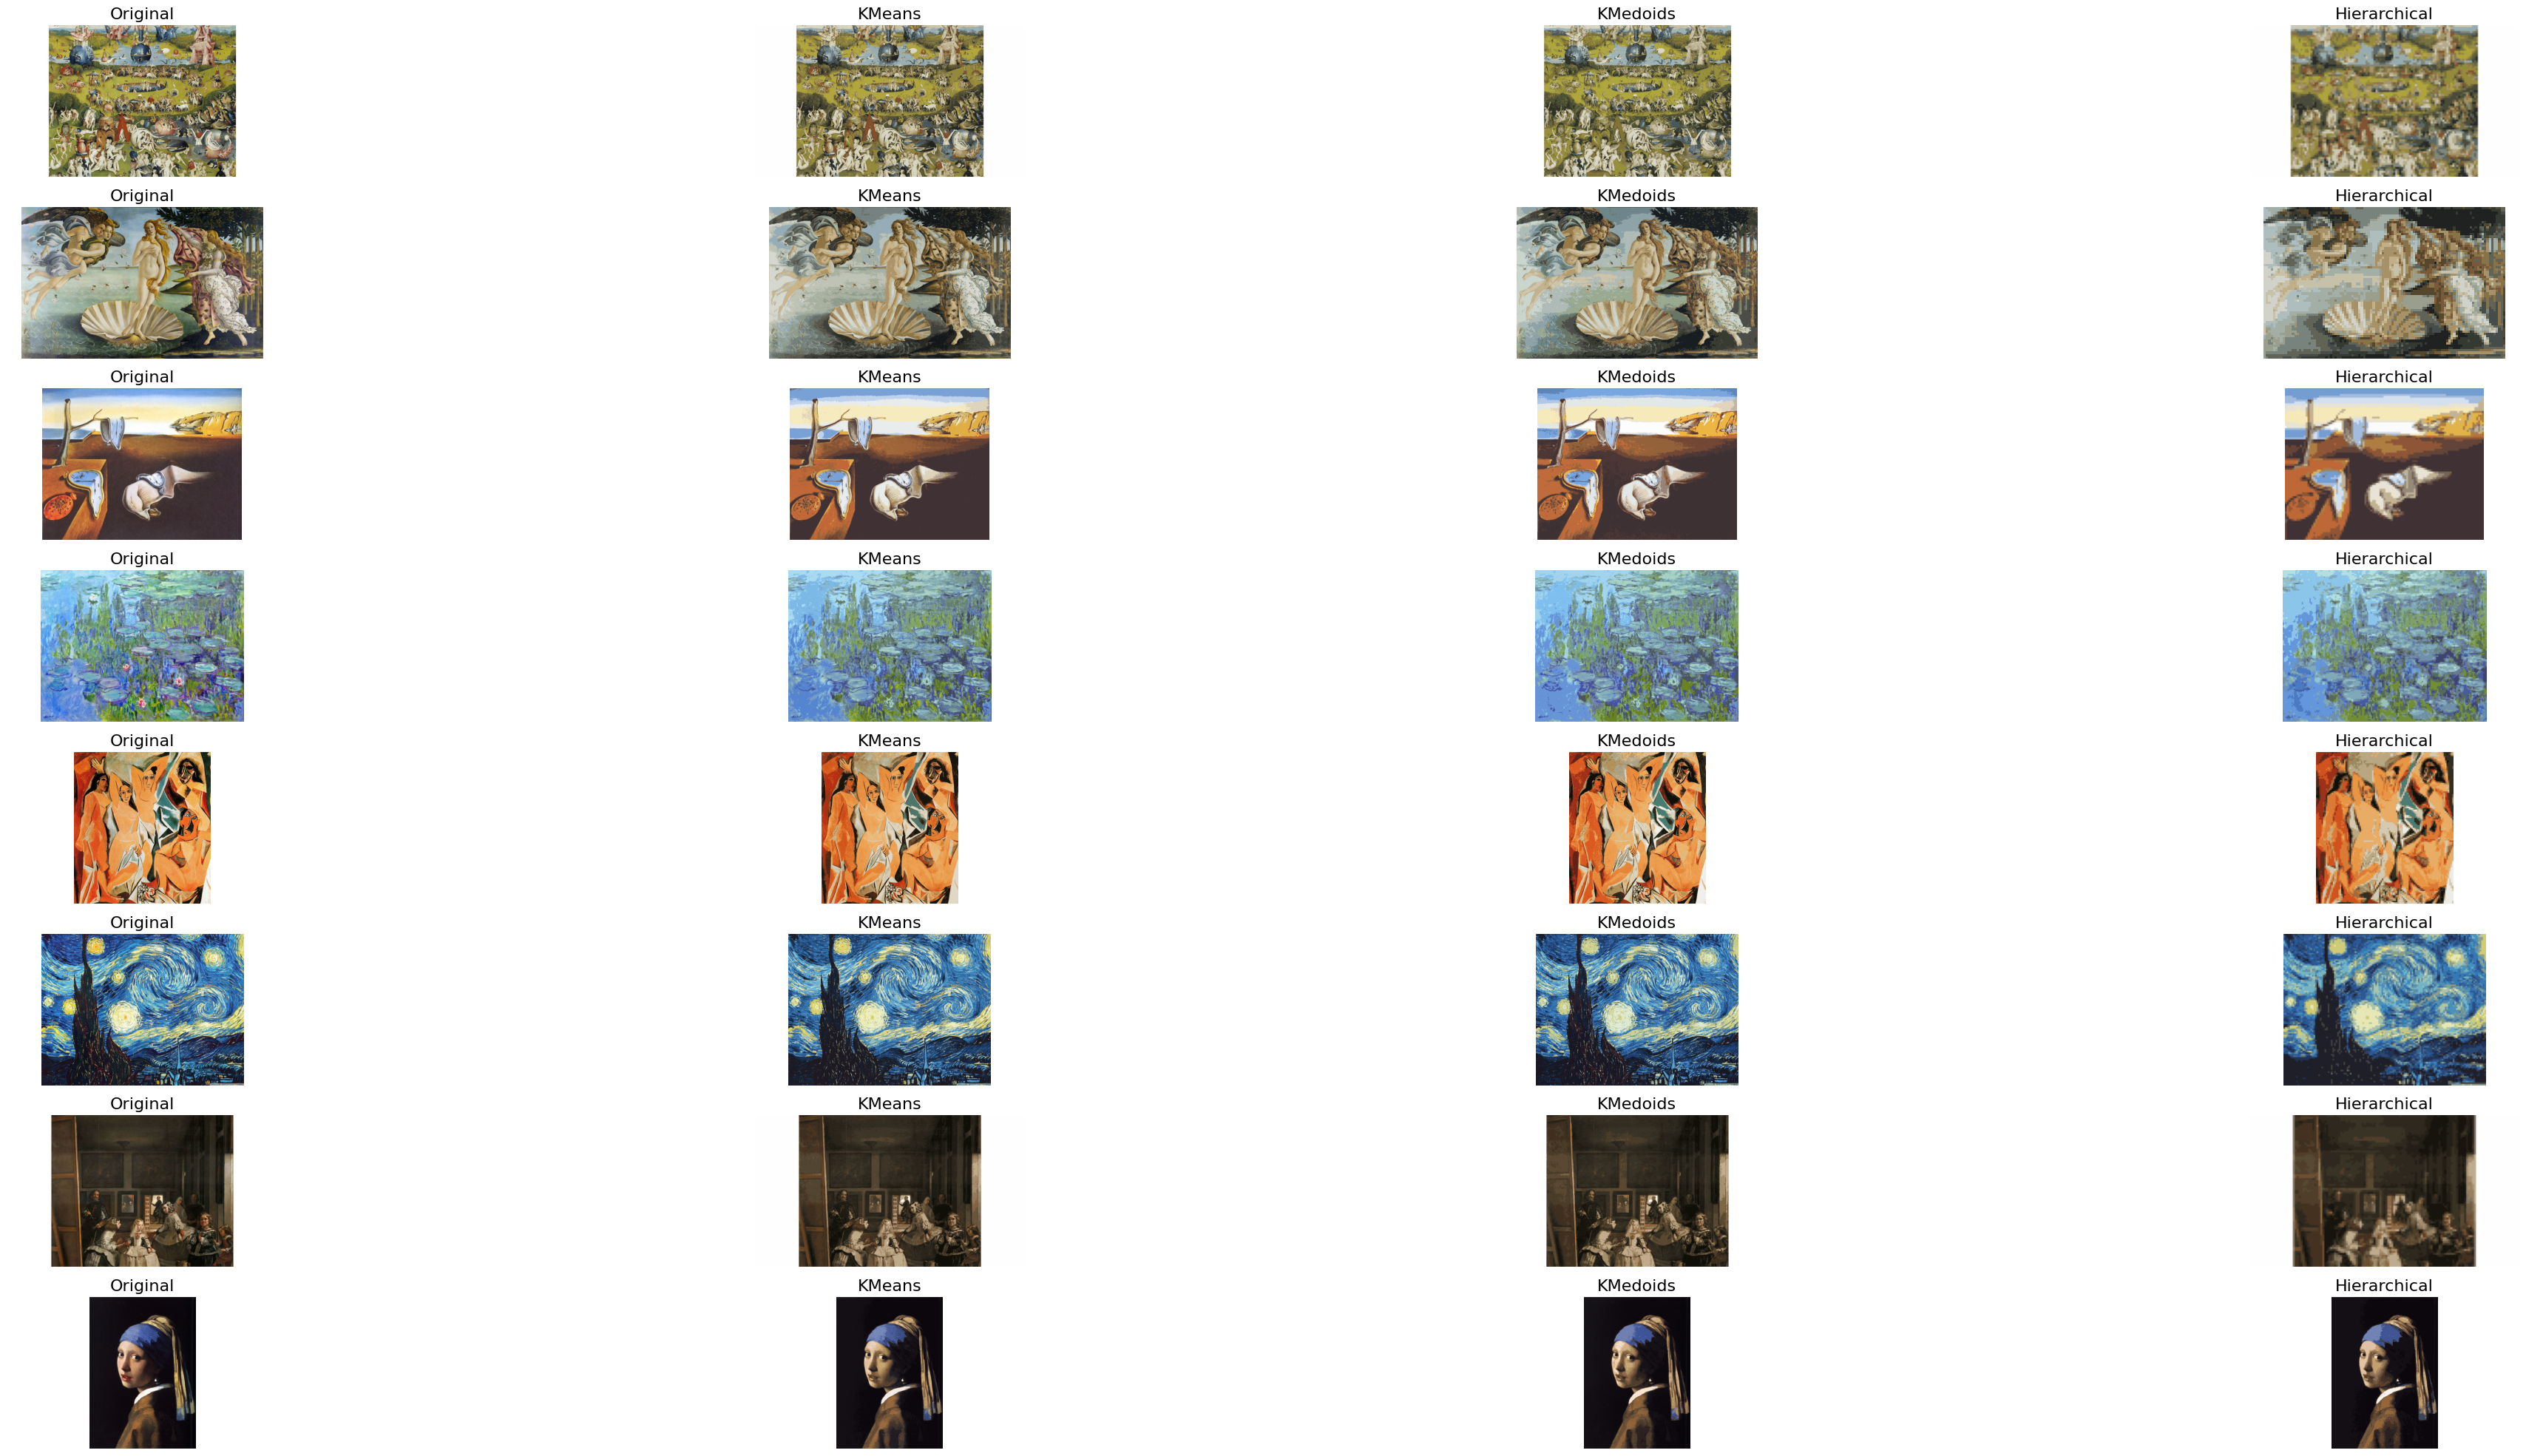

In [155]:
gallery(quantizations,img_names,figsize=(50,25))

## Imagen mejor cuantizada

La imagen mejor cuantizada de entre todo el grupo resulto ser "Las Meninas" de Velázquez
Esto se logro determinar a través de los valores de SSIM y Delta-E entre las diferentes imágenes, que pueden verse en la galería pasandolé el argumento de extended como True. 

Veamos a continuación una comparación entre las diferentes cuantizaciones y sus resultados

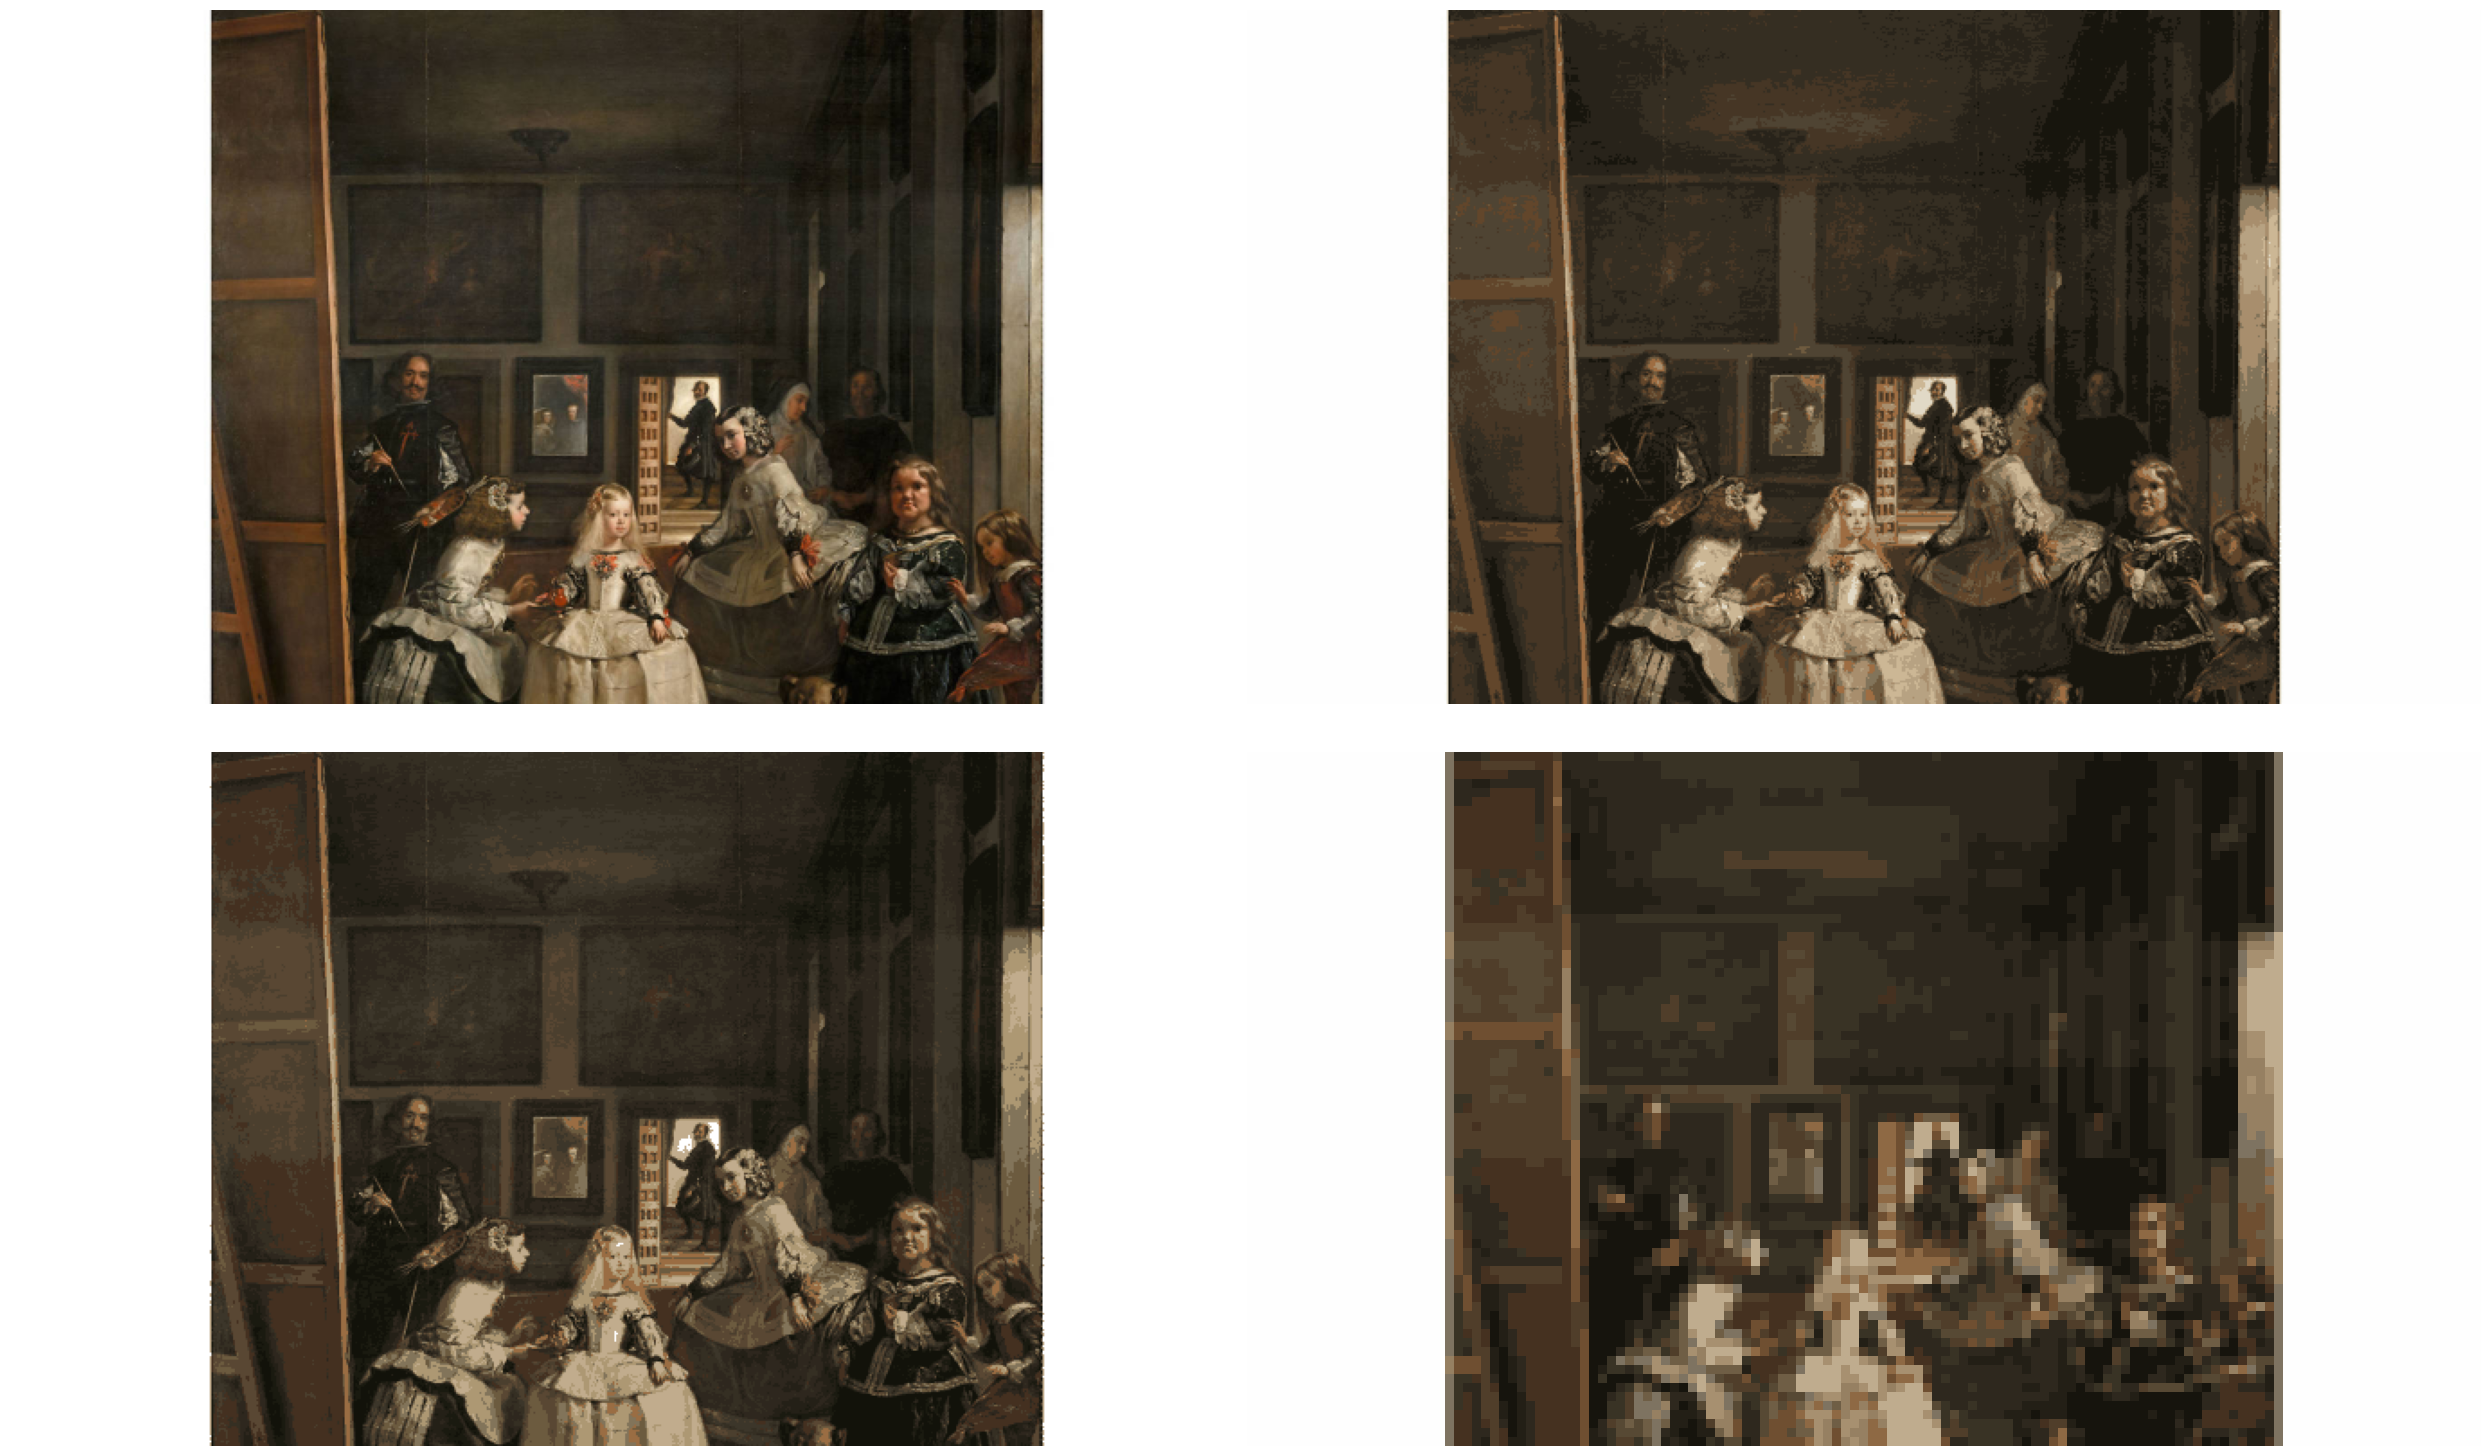

In [196]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(25,15))
methods = ['kmeans', 'kmedoids', 'hierarchical']


axs[0,0].imshow(cv2.cvtColor(quantizations['kmeans']['Velazquez']['org'], cv2.COLOR_BGR2RGB))

axs[0,1].imshow(cv2.cvtColor(quantizations['kmeans']['Velazquez']['red'], cv2.COLOR_BGR2RGB))

axs[1,0].imshow(cv2.cvtColor(quantizations['kmedoids']['Velazquez']['red'], cv2.COLOR_BGR2RGB))

axs[1,1].imshow(cv2.cvtColor(quantizations['hierarchical']['Velazquez']['red'], cv2.COLOR_BGR2RGB))


for i in range(2):
    axs[i,0].axis('off')
    axs[i,1].axis('off')

# Adjust layout and reduce whitespace
plt.subplots_adjust(wspace=0.05, hspace=0.2)  # Adjust these values to your preference
plt.tight_layout()

plt.show()

Como puede observarse, la imagen original cuenta con algunos colores generales bastante parecidos y un fuerte predominio de los colores oscuros y algunos próximos al blanco, lo que facilitaría el proceso de cuantización por parte de los algoritmos para estos colores. Sin embargo, también hay que destacar que la pintura cuenta con varios detalles más pequeños, como el color del rubor o los cambios de tonalidades para simular la iluminación y las sombras que al ser considerablemente menores en comparación con el resto muy probablemente se pierdan al momento de cuantizarse, cosa que efectivamente ocurre cuando lo comparamos con los resultados de los algoritmos. 

Para la comparación, por los motivos expuestos anteriormente en la declaración de los métodos, no se tomará para completa evaluación al clustering jerárquico, pero se mostrarán sus resultados para poder mantener la variedad de métodos, ya que como vemos, debido al alto grado de reducción en resolución, la imagen resulta fuertemente pixelada. 

Si comparamos los resultados de Kmeans y Kmedoids, son bastante similares y corroboran lo expresado anteriormente, los colores menos representados, como el rojo y el anaranjado y las variaciones de tono usadas para ilumniación se pierden al reducir la paleta, sin embargo Kmedoids hace un mejor trabajo detectando estos valores y conservandolos, pero sufre por ello mismo colocandolos en algunos lugares donde no se encuentran en la imagen original, como es el caso del ejemplo de la Menina de cabello rubio en la imagen original, a la que Kmedoids agrega pixeles rojos en la parte baja de su vestido que no corresponden.

Kmeans por su parte si pierde bastante de estos detalles, pero es más suave su cuantización, pues los colores más presentes en la imagen se mantienen y pasan a reemplazar los valores faltantes, como puede verse en las partes rojas de los vestidos, los cuales pasan a tener tonalidades más cercanas al color café en substitución, así como el hecho de que la imagen parece más cercana al Blanco y Negro que en el caso de Kmedoids. Sin embargo, esto mismo le permite conservar y representar mejor las sombres y las ilumnaciones a comparación con Kmedoids, pues este último tiene lugares donde otorga demasiada iluminación a ciertas partes del cuadro. 

Jerárquico por su parte, si bien la gran reducción de calidad debido a su alto coste en espacio y su implementación ineficiente por parte de la líbreria, permite ver a grandes rasgos como se haría la cuantización y como se agruparían los colores al momento de reconstruirse la imagen. Permite deducir que tendría un desempeño similar a Kmedoids en materia de mantener colores como el rojo, que se encontraba menos representado y una conservación de las ilumniaciones bastante similar a Kmeans pero sin ser igual. 

Veamos los errores. 

In [192]:
errors = {
    "MSE":[],
    "SSIM":[],
    "Delta-E":[]
}
for m in methods:
    errors["MSE"].append(quantizations[m]['Velazquez']['metrics']['MSE'])
    errors["SSIM"].append(quantizations[m]['Velazquez']['metrics']['SSIM'])
    errors["Delta-E"].append(quantizations[m]['Velazquez']['metrics']['Delta-E'])


e = pd.DataFrame(errors,index=methods)
print(e)

                    MSE      SSIM   Delta-E
kmeans        20.797254  0.921068  2.810333
kmedoids      16.001546  0.942081  2.468077
hierarchical  16.941163  0.959294  2.367947


Al ver las diferencias entre los valores de cada método relativos a la imagen que usaron, vemos que la aproximación es bastante buena. 

Puede observarse el hecho de que MSE no es la mejor medición para determinar que tan parecido puede ser la cuantización, pues aunque sigue la tendencia de las otras medidas, su valor es considerablemente alto. 

Ahora bien, SSIM y Delta-E indican que las cuantizaciones hechas son bastante buenas, desde la perspectiva de cada uno: 
* El valor tan cercano de SSIM a 1 indica que la cuantización dio como resultado una imagen bastante similar pero no igual, cosa observable debido a la pérdida de algunos de los colores. Según esta medición, entre Kmeans y Kmedoids, Kmedoids es el que mejor desempeño tiene, y probablemente sea debido a que omite muchos menos colores que Kmeans a pesar de usar la misma cantidad de elementos en la paleta. 
* Para Delta-E, el valor cae en su rango donde las diferencias son visibles al ojo humano y pueden ser notados al darle un vistazo, pero son colores bastante similares y mantienen muy cercano el parecido a la imagen original.

De estos valores, podemos ver que Kmedoids tuvo un mejor rendimiento que Kmeans y realizo una mejor conservación de los valores de la imagen original. 

No se compara directamente con el clustering jerárquico, porque como se especificó antes, este trabajo con menos datos por lo tanto sería injusto realizar dicha comparación, aunque podría decirse que no tendría resultados malos y serían bastante similares pues tiene un comportamiento en resultados muy similar a Kmedoids

Contestar las siguientes preguntas:

1. ¿Esta a gusto con la cuantización realizada?
     De manera general sí, pues se retiene de forma bastante decente la idea original de la imagen, pudiendo representarse con un menor número de colores. Personalmente, la representación mediante kmeans, de los algoritmos utilizados es con la que más agusto me encuentro, pues en ciertos casos como 'La noche estrellada' de Van Gogh o 'Las señoritas de Aviñón' de Picaso, las reducciones fueron bastante buenas para la limitante de 15 clusters y sin presentar demasiadas complicaciones para entrenar el modelo. Y aunque se pierden algunos colores en los procesos, la imagen se mantiene con una paleta de colores que difiere al ojo humano más en detalles especifícos que en grandes elementos que podrían distorsionar su percepción. 
   
2. ¿Cómo puede mejorar los resultados?
    Para mejorar los resultados, habría que empezar desde el preprocesamiento, mediante la reducción de elementos muy repetidos para poder reducir los efectos de la sobre-representación de algunos colores y tratar de conservar algunos de los menos representados para que al momento de hacer el clustering, los valores se mantengan o sean más cercanos y similares disminuyendo la pérdida de tonalidades y expresividad en comparación con la original.

   También, la optimización de algunos algoritmos para poder reducir el tamaño en memoría empleado y en algunos casos el costo temporal, como en los casos de kmedoids y Clustering Jerárquico para que puedan trabajar con datasets o imágenes más grandes, reduciendo de esta forma los costos computacionales que si bien en este proyecto son meramente en materia de tiempo, en el mundo real estos se traducen en forma de costos monetarios o un mayor nivel de dificultad de implementación para poder ajustar los datos a párametros más razonables de usarse estos algoritmos.

   Por último, de no poderse el apartado anterior, utilizar algoritmos los cuales escalen mejor en eficiencia respecto al tamaño del dataset, para que al utilizar menos recursos que los anteriores, se pueden buscar resultados aún más precisos y con menos costos al momento de usarlos. 

   
3. Describa brevemente que han hecho los algoritmos de clustering y sus diferencias. Puede usar figuras, gráficas, etc para complementar esta respuesta.

    De forma general, cada uno de los algoritmos ha creado grupos o clusters que representan un color dentro de la paleta general y para realizar la reducción, ha ido asignando cada pixel de la imagen a uno de estos clusters, basandose en la distancia o lo que sería lo mismo, que tan similares son con el centro determinado y calculando el nuevo valor del centroide tras cada pixel agregado. De esta forma, al momento de reconstruir la imagen, se sustituyen las pluralidad de colores por esta paleta limitada y cada pixel toma el color del cluster al que fue asignado.

   Las diferencias entre los métodos, radican en como se escogen estos clusters. Kmeans por ejemplo, para escoger el cluster realiza el cálculo completo de la media de todos los elementos pertenecientes hasta ese momento y mueve el centroide en base a este valor, independientemente si este existe dentro de los elementos de dicho cluster; por otro lado, Kmedoids hace el mismo proceso exceptúando que este si garantiza escoger uno de los valores existentes en el cluster, donde si el cálculo de la media no es un valor dentro de los que se encuentran en el cluster, escogerá al elemento con menor distancia de ese valor, siendo además menos propenso a ver sus valores movido por outliers. Por otro lado, clustering jerárquico agrupa los píxeles más similares y luego agrupa esos clusters de manera jerárquica hasta formar un árbol de clusters. 


5. ¿Qué problemas tuvo a la hora de realizar esta parte del proyecto?
       Uno de los mayores inconvenientes al momento de realizar esta parte del proyecto, fue la gran cantidad de elementos que componen las imagénes y el nivel de complejidad espacial de algunos algoritmos considerados como Clustering Jerárquico o Kmedoids, con un costo de $O(n^2)$, y que sus implementaciones en las líbrerias no eran las más eficientes en este aspecto; lo que generaba un alto consumo de memoria de almacenamiento que en muchos casos sobrepasaba la poseída por el ordenador, impidiendo realizar la cuantización.
   Esto obligó a que se buscasen métodos para reducir la cantidad de píxeles que componian la imagen, pero al mismo tiempo tratando de mantener la calidad y la fidelidad lo más cercana posible a la original , ya que de no ser así, podrían perderse ciertos colores que no estuviesen muy representados en la imagen o reducir demasiado su representación, lo que se propagaba al momento de cuantizar donde dichos colores se perdían definitivamente.

   Esto también señala de forma tangencial otro de los problemas y era la sobre-representación de algunos colores y la sub-representación de otros, lo que daba lugar a que en ciertas pinturas, al momento de cuantizarlas, los pixeles subrepresentados tendían a desaparecer de las paletas generadas por los algoritmos de clustering y en ciertos casos los colores más dominantes o que se superponían a los demás terminaban siendo los sobre-representados, llegando a aparecer en lugares que no estaban antes a manera de substituto de los que desaparecieron. 